# Reinforcement Learning: Double Deep Q Networks using Pytorch

### Custom Environment to train our model on

In [1]:
import gym
from gym import spaces

import numpy as np
import random
from copy import deepcopy


class gridworld_custom(gym.Env):

    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, *args, **kwargs):
        super(gridworld_custom, self).__init__()

        self.current_step = 0

        self.reward_range = (-10, 100)

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(low=np.array(
            [0, 0]), high=np.array([4, 4]), dtype=np.int64)

        self.target_coord = (4, 4)
        self.death_coord = [(3, 1), (4, 2)]

    def Reward_Function(self, obs):

        if (obs[0] == self.target_coord[0] and obs[1] == self.target_coord[1]):
            return 20
        elif (obs[0] == self.death_coord[0][0] and obs[1] == self.death_coord[0][1]) or \
                (obs[0] == self.death_coord[1][0] and obs[1] == self.death_coord[1][1]):
            return -10
        else:
            return -1

        return 0

    def reset(self):
        self.current_step = 0

        self.prev_obs = [random.randint(0, 4), random.randint(0, 4)]

        if (self.prev_obs[0] == self.target_coord[0] and self.prev_obs[1] == self.target_coord[1]):

            return self.reset()

        return self.prev_obs

    def step(self, action):

        action = int(action)

        self.current_step += 1

        obs = deepcopy(self.prev_obs)

        if(action == 0):
            if(self.prev_obs[0] < 4):
                obs[0] = obs[0] + 1
            else:
                obs[0] = obs[0]

        if(action == 1):
            if(self.prev_obs[0] > 0):
                obs[0] = obs[0] - 1
            else:
                obs[0] = obs[0]

        if(action == 2):
            if(self.prev_obs[1] < 4):
                obs[1] = obs[1] + 1
            else:
                obs[1] = obs[1]

        if(action == 3):
            if(self.prev_obs[1] > 0):
                obs[1] = obs[1] - 1
            else:
                obs[1] = obs[1]

        reward = self.Reward_Function(obs)

        if (obs[0] == self.target_coord[0] and obs[1] == self.target_coord[1]) or (self.current_step >= 250):
            done = True
        else:
            done = False

        self.prev_obs = obs

        return obs, reward, done, {}

    def render(self, mode='human', close=False):

        for i in range(0, 5):
            for j in range(0, 5):
                if i == self.prev_obs[0] and j == self.prev_obs[1]:
                    print("*", end=" ")
                elif i == self.target_coord[0] and j == self.target_coord[1]:
                    print("w", end=" ")
                elif (i == self.death_coord[0][0] and j == self.death_coord[0][1]) or \
                     (i == self.death_coord[1][0] and j == self.death_coord[1][1]):
                    print("D", end=" ")
                else:
                    print("_", end=" ")
            print()

        print()
        print()


### Import required Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from tqdm.auto import tqdm
from tqdm import tqdm

### Build The neuralnet

In [4]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(NeuralNetwork, self).__init__()
        
        self.layer1 = nn.Linear(2, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 4)
        
    def forward(self, x):
        
        l1 = self.layer1(x)
        l1 = F.relu(l1)
        l2 = self.layer2(l1)
        l2 = F.relu(l2)
        l3 = self.layer3(l2)
        
        output = l3
        
        return output

#### Check to see if there is a GPU which can be used to accelerate the workflows

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Force Use a Device
#device = 'cuda' #for GPU
#device = 'cpu'  #for CPU

print(f'Using {device} device')

Using cuda device


### Initialize the neuralnets

In [6]:
q_network = NeuralNetwork().to(device)
target_network = deepcopy(q_network)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(q_network.parameters(), lr = 1e-3)

### Initialise the environment

In [7]:
env = gridworld_custom()

#### Check up the functionality of epsilon greedy. Just for reference.

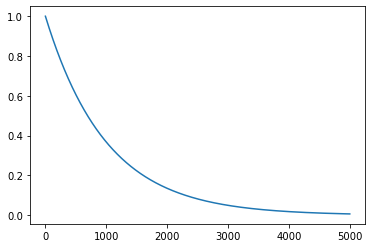

In [8]:
epsilon = 1
epsilon_decay = 0.999

episodes = 5000
epsilon_copy = deepcopy(epsilon)
eps = []

for i in range(episodes):
    epsilon_copy = epsilon_copy * epsilon_decay
    eps.append(epsilon_copy)

plt.plot(eps)
plt.show()

### Run everything

In [9]:
gamma = 0.99

batch_size = 32

pbar = tqdm(range(episodes))

episode_loss = 0.0

target_network_update_freq = 5

for episode in pbar:
    
    prev_obs = env.reset()
    done = False
    mem_size = 0
    
    curr_state_mem = np.array([[0,0]] * batch_size)
    prev_state_mem = np.array([[0,0]] * batch_size)
    action_mem = np.array([0] * batch_size)
    reward_mem = np.array([0] * batch_size)
    
    epsilon = epsilon * epsilon_decay

    while not(done) :
        
        if(random.uniform(0, 1) > epsilon):
            with torch.no_grad():
                prev_q = q_network(torch.tensor(prev_obs, device=device).float())
                prev_q = prev_q.cpu().detach().numpy()
            action = np.argmax(prev_q)
        else:
            action = random.randint(0,3)

        obs, reward, done, _ = env.step(action)

        prev_state_mem[mem_size] = prev_obs
        curr_state_mem[mem_size] = obs
        action_mem[mem_size] = action
        reward_mem[mem_size] = reward
        mem_size = mem_size + 1

        prev_obs = obs

        if(mem_size == batch_size):

            target_q = q_network(torch.tensor(prev_state_mem, device=device).float()).gather(1, torch.tensor(action_mem, device=device).type(torch.int64).unsqueeze(1)).squeeze(1)

            expected_q_mem = torch.tensor(reward_mem, device=device).float() + ( gamma * target_q )

            with torch.no_grad():
                network_q_mem = target_network(torch.tensor(curr_state_mem, device=device).float()).max(1)[0].detach()

            loss = loss_function(expected_q_mem, network_q_mem)

            episode_loss = "{:.3f}".format(loss.item())
            
            mem_size = 0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_network_update_freq == 0:
        target_network = deepcopy(q_network)

    pbar.set_description("loss = %s" % episode_loss)

loss = 1665.557: 100%|████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.63it/s]


### Test the trained model

In [10]:
prev_obs = env.reset()
done = False
env.render()
while not(done):
    with torch.no_grad():
        prev_q = q_network(torch.tensor(prev_obs, device=device).float())
        prev_q = prev_q.cpu().detach().numpy()
    action = np.argmax(prev_q)
    obs, reward, done, _ = env.step(action)
    prev_obs = obs
    env.render()

_ _ _ _ _ 
_ * _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ * _ _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ * _ _ 
_ D _ _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D * _ _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ * _ 
_ _ D _ w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
_ _ D * w 


_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ _ _ 
_ D _ _ _ 
_ _ D _ * 


